# Fake news detection on tweets using the PHEME dataset

## Aim
In this notebook our aim is to use RNN and Attention layers, to approach the task of fake news detection. For the task we used the PHEME dataset.

The dataset can be downloaded here: https://figshare.com/articles/dataset/PHEME_dataset_for_Rumour_Detection_and_Veracity_Classification/6392078

This dataset contains a collection of Twitter rumours and non-rumours posted during breaking news. More specifically, it contain Twitter conversation threads associated with different newsworthy events including the Ferguson unrest, the shooting
at Charlie Hebdo, the shooting in Ottawa, the hostage situation in Sydney and the crash of a Germanwings
plane, and others.


The data is structured as follows. Each event has a directory, with two subfolders, rumours and non-rumours. These two folders have folders named with a tweet ID. The tweet itself can be found on the 'source-tweet' directory of the tweet in question, and the directory 'reactions' has the set of tweets responding to that source tweet. Also each folder contains ‘annotation.json’ which contains information about veracity of the rumour and ‘structure.json’, which contains information about structure of the conversation.

*Notice that for our task, fake news detection, we used only the source tweets classified as rumours in the dataset.*

In [1]:
# in case of exceeding memory, we found useful install this version of tensorflow
# execute this cell, then press 'Restart and clear cell outputs' and execute all cells except this
#!pip install -U tensorflow==2.6.3

Pay attention to the libraries version you install, we learn this on our skin :-)

***Tip***: You can pin the Environment to the original one in  the Settings. You won't get latest packages version, but your code will be less likely to break.

In [2]:
import numpy as np 
np.__version__

'1.19.5'

In [3]:
import tensorflow as tf
tf.__version__

2022-08-05 09:45:00.980069: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


'2.4.1'

In [4]:
import pandas as pd 
import os
import json
import shap
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from sklearn import preprocessing

import nltk # NLP  
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
import re  

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

In [6]:
# seed initialization
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)

## Let's build our Dataset

In [7]:
#going to our dataset directory
%cd ../input/pheme-dataset/all-rnr-annotated-threads_1

/kaggle/input/pheme-dataset/all-rnr-annotated-threads_1


The tweets downloaded using the Twitter API have a lot features. We choose the ones more suited for our task. 

The data dictionary can be found here: https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview


In [8]:
# set the folders to iterate on
folds= ['charliehebdo-all-rnr-threads','ottawashooting-all-rnr-threads',
'ebola-essien-all-rnr-threads','prince-toronto-all-rnr-threads',
'ferguson-all-rnr-threads',	'putinmissing-all-rnr-threads',
'germanwings-crash-all-rnr-threads',
'gurlitt-all-rnr-threads','sydneysiege-all-rnr-threads']

#these are our candidate features, some of them will be dropped

texts = []
fav_counts = []
retweet_counts = []
date = []

username = []
account_date = []
protected = []
verified = []
followers = []
followings = []
tweets_count = []

hashtag = []
url = []

events = []
y = []

In [9]:
# the annotations on PHEME have 2 boolean values, 'misinformation' value and 'true' value, we want to convert them in a single label with values
# 'true', 'false' or 'unverified'. This values can be string or numerical, depending on the 'string' parameter of the function
def convert_annotations_data(annotation, string = True):
    if 'misinformation' in annotation.keys() and 'true'in annotation.keys():
        if int(annotation['misinformation'])==0 and int(annotation['true'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==0 and int(annotation['true'])==1 :
            if string:
                label = "true"
            else:
                label = 1
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==0 :
            if string:
                label = "false"
            else:
                label = 0
        elif int(annotation['misinformation'])==1 and int(annotation['true'])==1:
            print ("OMG! They both are 1!")
            print(annotation['misinformation'])
            print(annotation['true'])
            label = None
            
    elif 'misinformation' in annotation.keys() and 'true' not in annotation.keys():
        # all instances have misinfo label but don't have true label
        if int(annotation['misinformation'])==0:
            if string:
                label = "unverified"
            else:
                label = 2
        elif int(annotation['misinformation'])==1:
            if string:
                label = "false"
            else:
                label = 0
                
    elif 'true' in annotation.keys() and 'misinformation' not in annotation.keys():
        print ('Has true not misinformation')
        label = None
    else:
        print('No annotations')
        label = None
           
    return label

In [10]:
# navigate the folders to create our dataset. In our task we only use the source tweets that are rumours
for f in folds:
  path1 = os.path.join(f, 'rumours')
  for dir1 in os.listdir(path1):
        if '_' not in dir1:
          path_target  = os.path.join(path1,dir1,'annotation.json')
          file = open(path_target)
          data = json.load(file)
          target = convert_annotations_data(data)
          y.append(target)
          path2 = os.path.join(path1, dir1,'source-tweets')
          for dir2 in os.listdir(path2):
            if '_' not in dir2:
              path3  = os.path.join(path2,dir2)
              file = open(path3)
              data = json.load(file)
            
              #tweet features
              text = data['text']
              tweet_date = data['created_at']
              fav = data['favorite_count']
              retw = data['retweet_count']
                
              #user features
              usernames = data['user']['screen_name']
              account_creation = data['user']['created_at']
              is_protected = data['user']['protected']
              is_verified = data['user']['verified']
              no_followers = data['user']['followers_count']
              no_followings = data['user']['friends_count']
              no_tweets = data['user']['statuses_count']
                
              #entities
              no_hashtags = len(data['entities']['hashtags'])      
              has_url = data['entities']['urls']  
              text = data['text']
              fav = data['favorite_count']
              retw = data['retweet_count']
              
              texts.append(text)
              date.append(tweet_date)
              fav_counts.append(fav)
              retweet_counts.append(retw)
                                     
              username.append(usernames)
              account_date.append(account_creation)
              protected.append(is_protected)
              verified.append(is_verified)
              followers.append(no_followers)
              followings.append(no_followings)
              tweets_count.append(no_tweets)
            
              
              hashtag.append(no_hashtags)
              url.append(has_url)
            
              events.append(f)

In [11]:
df = pd.DataFrame([texts,date,fav_counts,retweet_counts,username,account_date,followers,followings,tweets_count,protected,verified,hashtag,url,events,y],['text','date','fav_count','retweet_count','username','account_date','followers','followings','tweet_count','protected','verified','no_hashtags','urls','event','target']).transpose()
df = df.infer_objects()
df.head()

# drop categorical data and protected which has 0 var
df.drop(["date","username","account_date","urls","protected"], axis=1, inplace=True)

#convert boolen features into numerical
df = df.astype({"verified":'int64'})
df.dtypes

text             object
fav_count         int64
retweet_count     int64
followers         int64
followings        int64
tweet_count       int64
verified          int64
no_hashtags       int64
event            object
target           object
dtype: object

In [12]:
df.head()

,text,fav_count,retweet_count,followers,followings,tweet_count,verified,no_hashtags,event,target
0,Now we are confirming 10 dead in #Paris #Charl...,7,196,2064,829,3806,0,2,charliehebdo-all-rnr-threads,true
1,#UPDATE Three men including two brothers ident...,18,107,297225,482,64514,1,3,charliehebdo-all-rnr-threads,true
2,Breaking: Armed men attack offices of French s...,33,279,5577526,974,104493,1,0,charliehebdo-all-rnr-threads,true
3,#CharlieHebdo famous cartoonists Charb and Cab...,62,339,969090,1763,123741,1,1,charliehebdo-all-rnr-threads,false
4,BREAKING: Gunfire reported in French town as p...,24,119,2235125,139,134814,1,1,charliehebdo-all-rnr-threads,unverified


## Text cleaning and preparation

In [13]:
!pip install contractions
import contractions

     |████████████████████████████████| 106 kB 909 kB/s eta 0:00:01
     |████████████████████████████████| 287 kB 4.3 MB/s eta 0:00:01


In [14]:
# is, not, an: stopwords
from nltk.corpus import stopwords


def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_characters(text):
    return re.sub('[^a-zA-Z]', ' ', text)

def remove_url(text):
    return re.sub(r'http\S+', '', text)

import contractions
def remove_contractions(text):
    return ' '.join([contractions.fix(word) for word in text.split()])

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(text):
    return ' '.join([word for word in nltk.word_tokenize(text) if word not in stop_words])
# str(text).split()

#importing the Lemming function from nltk library
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
lemmatizer = WordNetLemmatizer()
#defining a function for lemming
def lemmatize_words(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

#importing the Stemming function from nltk library
from nltk.stem.porter import PorterStemmer
#defining the object for stemming
stemmer = PorterStemmer()
#defining a function for stemming
def stemming_words(text):
    return ' '.join(stemmer.stem(word) for word in text.split())

def clean_text(text):
    text = remove_url(text)
    text = remove_contractions(text)
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords(text)
    #text = stemming_words(text)
    #text = lemmatize_words(text)
    return text
    
# apply
df['text'] = df['text'].apply(clean_text)

## Build our model

#### In our model we implemented an attention layer, refer to [this tutorial](https://analyticsindiamag.com/hands-on-guide-to-bi-lstm-with-attention/) for more detailed instruction

In [15]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences

        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        super(attention,self).build(input_shape)
    
    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)
    

#### Let's build our model using the Keras API
Working with both sequential data (the text of the tweet) and static data (metadata for each tweet), we decided to implement a model having two head to manage these two different kinds of input.




In [16]:
# the hyperparameters were found using Keras Tuner

def build_model(max_len, num_words, embedding_dim, static_input_shape):
   
    # RNN layers
    seq_input = tfkl.Input([max_len], name = "Sequential_Input")
    emb_layer = Embedding(num_words,
                        embedding_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=max_len,
                        trainable=True, name = "Embedding")(seq_input)
    emb_layer = tfkl.SpatialDropout1D(0.2, seed=seed)(emb_layer)
    rec_layer1 = tfkl.Bidirectional(LSTM(80, return_sequences= True), name = "Recurrent1")(emb_layer)
    rec_layer2 = tfkl.Bidirectional(LSTM(80, return_sequences= True), name = "Recurrent2")(rec_layer1)
    rec_layer3 = tfkl.Bidirectional(LSTM(140, return_sequences= True), name = "Recurrent3")(rec_layer2)
    rec_layer4 = tfkl.Bidirectional(LSTM(40,return_sequences= True), name = "Recurrent4")(rec_layer3)
    attention_layer = attention(return_sequences = False)(rec_layer4)
    drop_layer = tfkl.Dropout(0.2, seed=seed)(attention_layer)    

    #Static Single Layer Percetron
    static_input = tfkl.Input(static_input_shape,name = "Static_Input")
    norm_input = tfkl.BatchNormalization()(static_input)
    static_layer1 = Dense(32,  kernel_regularizer=tfk.regularizers.L2(0.001),  activation='relu',name="Static_dense_1")(norm_input)

    #RNN + Static
    combined = tfkl.Concatenate(axis= 1,name = "Concatenated")([drop_layer,static_layer1])
    combined_norm1 = tfkl.BatchNormalization()(combined)
    combined_dense1 = Dense(192, activation='relu',name="Combined_dense1")(combined_norm1)

    output_layer = Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotNormal(seed), name='Output')(combined_dense1)

    #Compile model
    model = Model(inputs=[seq_input,static_input],outputs=[output_layer], name = "Megazord_Model")
    model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics = ['accuracy'])

    #to reduce verbosity comment this
    #print(model.summary())
    return model

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callback = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
# load the GloVe vectors in a dictionary: (it takes some time...)

embeddings_index = {}
f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [03:49, 9587.48it/s] 

Found 2196017 word vectors.


In [19]:
%cd /kaggle/working

/kaggle/working


In [20]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## About Leave One Event Out (LOEO) 

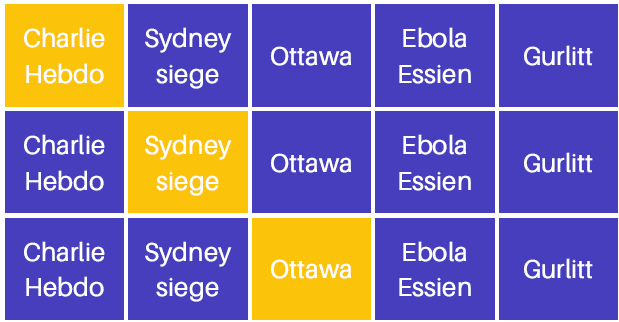


So at first we measured the accuracy with random train-test split, obtaining 82% from the start. Beautiful, but wrong.

Why it was wrong? What we wanted was a model that learn high level pattern in the text and numerical features to detect fake news. But by splitting the tweets of the same event in training and test the model was learning knowledge about the events, and we were measuring that. So if during training all true tweets said that Charlie Hebdo was in Paris, when a test tweet was saying that Charlie Hebdo was in Berlin, that  was classified as false but for the wrong reasons.

So we address this by using a LOEO CV. Thinkof this as a K fold Cross Validation but using as test fold one single event never seen in the training.
And this gave us a lower score of course, but more reliable.



model using as test set:  charliehebdo-all-rnr-threads
size of the test set:  4580


100%|██████████| 3721/3721 [00:00<00:00, 169240.33it/s]
2022-08-05 09:50:08.866511: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-05 09:50:08.869620: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-05 09:50:08.938553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 09:50:08.939248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-08-05 09:50:08.939311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-05 09

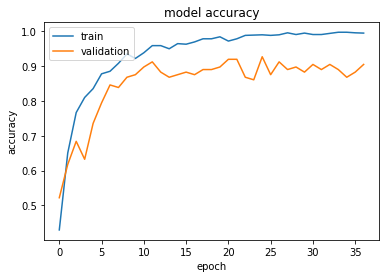

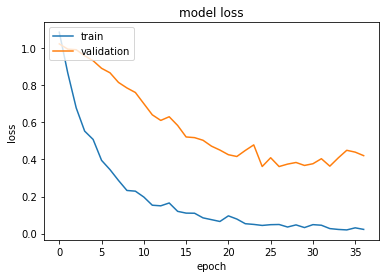

15/15 [==============================] - 3s 203ms/step - loss: 2.3706 - accuracy: 0.3166
model using as test set:  ottawashooting-all-rnr-threads
size of the test set:  4700


100%|██████████| 3721/3721 [00:00<00:00, 188024.88it/s]


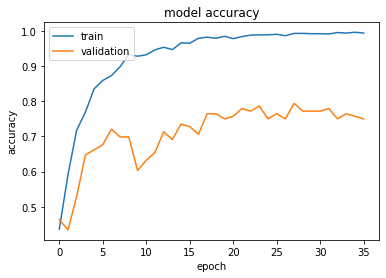

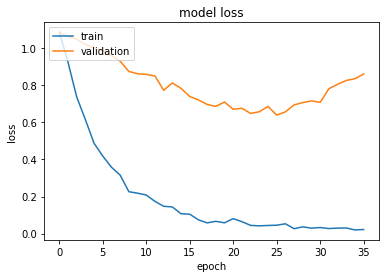

15/15 [==============================] - 3s 201ms/step - loss: 1.6314 - accuracy: 0.4851
model using as test set:  ebola-essien-all-rnr-threads
size of the test set:  140


100%|██████████| 3721/3721 [00:00<00:00, 178825.61it/s]


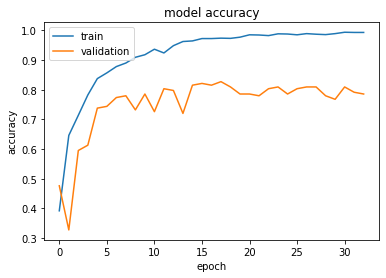

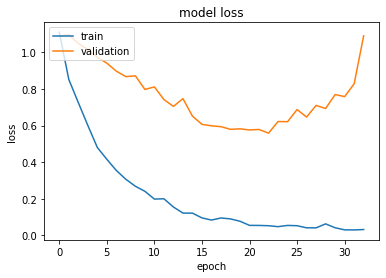

1/1 [==============================] - 0s 184ms/step - loss: 5.8151 - accuracy: 0.0714
model using as test set:  prince-toronto-all-rnr-threads
size of the test set:  2290


100%|██████████| 3721/3721 [00:00<00:00, 119254.88it/s]


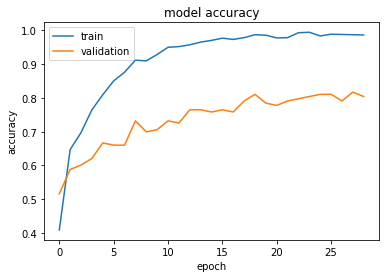

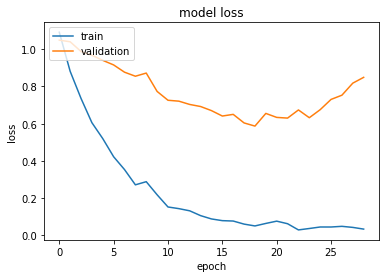

8/8 [==============================] - 2s 201ms/step - loss: 4.3541 - accuracy: 0.0262
model using as test set:  ferguson-all-rnr-threads
size of the test set:  2840


100%|██████████| 3721/3721 [00:00<00:00, 229060.03it/s]


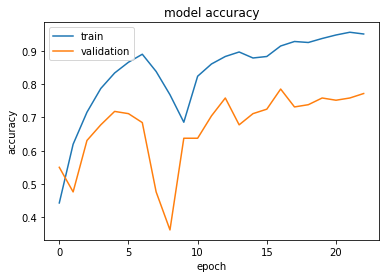

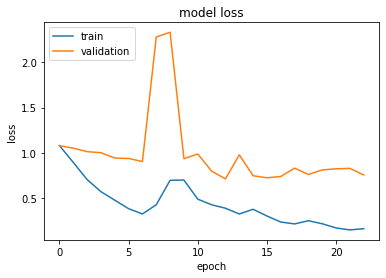

9/9 [==============================] - 2s 217ms/step - loss: 2.6184 - accuracy: 0.2430
model using as test set:  putinmissing-all-rnr-threads
size of the test set:  1260


100%|██████████| 3721/3721 [00:00<00:00, 275605.80it/s]


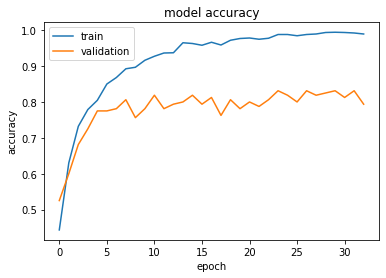

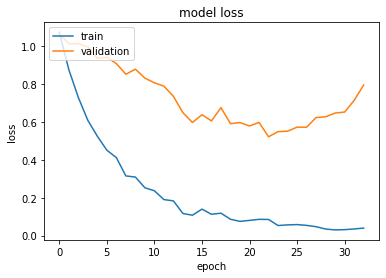

4/4 [==============================] - 1s 207ms/step - loss: 1.9858 - accuracy: 0.4127
model using as test set:  germanwings-crash-all-rnr-threads
size of the test set:  2380


100%|██████████| 3721/3721 [00:00<00:00, 261401.98it/s]


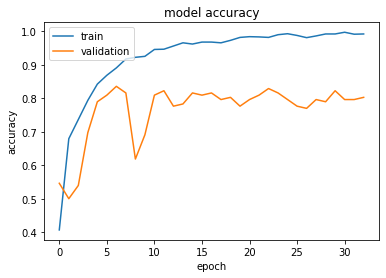

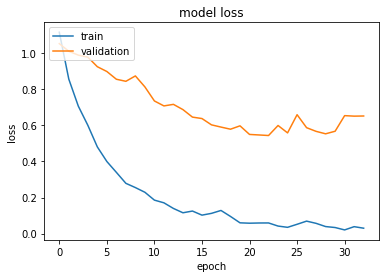

8/8 [==============================] - 2s 195ms/step - loss: 3.1286 - accuracy: 0.1681
model using as test set:  gurlitt-all-rnr-threads
size of the test set:  610


100%|██████████| 3721/3721 [00:00<00:00, 259265.50it/s]


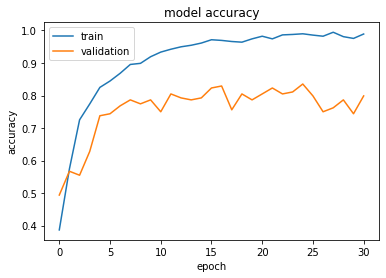

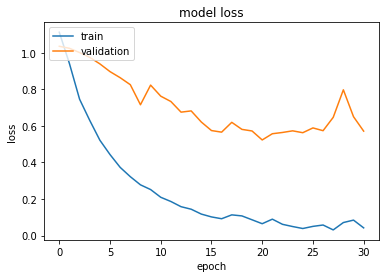

2/2 [==============================] - 0s 205ms/step - loss: 3.3669 - accuracy: 0.0328
model using as test set:  sydneysiege-all-rnr-threads
size of the test set:  5220


100%|██████████| 3721/3721 [00:00<00:00, 265371.10it/s]


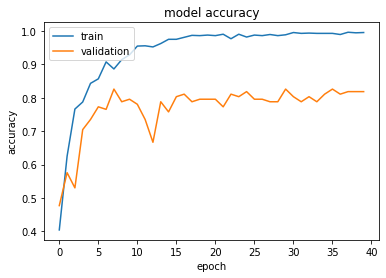

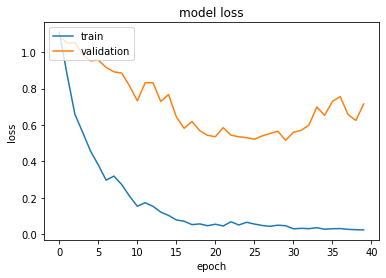

17/17 [==============================] - 4s 209ms/step - loss: 2.3648 - accuracy: 0.4100


In [21]:
#all features except date & account_data & username

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
lb = LabelBinarizer()
metrics = []

#here we use Leave One Event Out Cross Validation: we test our model on the one event it has never seen during the training
for f in folds:
    
    df_train = df[df['event']!=f]
    df_test = df[df['event']==f]
    
    print('model using as test set: ', f)
    print('size of the test set: ',df_test.size)
    
    X_train, X_val, y_train, y_val = train_test_split(df_train[['text','fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']], df_train['target'], test_size=0.3, random_state=0)
    
    X_test = df_test[['text','fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    y_test = df_test['target']

    X_train_static_ns = X_train[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    X_val_static_ns = X_val[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    X_test_static_ns = X_test[['fav_count','retweet_count','followers','followings','tweet_count','verified','no_hashtags']]
    
    #normalize training folds
    scaler = preprocessing.StandardScaler().fit(X_train_static_ns)
    X_train_static = scaler.transform(X_train_static_ns)
    
    #normalize the validation and test
    X_val_static = scaler.transform(X_val_static_ns)
    X_test_static = scaler.transform(X_test_static_ns)
    
    
    X_train = X_train['text']
    X_val = X_val['text']
    X_test = X_test['text']

    
    # using keras tokenizer here
    token = Tokenizer(num_words=None)
    max_len = 1500

    token.fit_on_texts(list(X_train) + list(X_val) + list(X_test))
    xtrain_seq = token.texts_to_sequences(X_train)
    xval_seq = token.texts_to_sequences(X_val)
    xtest_seq = token.texts_to_sequences(X_test)

    #zero pad the sequences
    xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
    xval_pad = sequence.pad_sequences(xval_seq, maxlen=max_len)
    xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

    word_index = token.word_index

    y_train = lb.fit_transform(y_train)
    y_val = lb.transform(y_val)
    y_test = lb.transform(y_test)

    # can be set later: nr of words we care about max_features = 0
    num_words =  len(word_index) + 1
    
    embedding_dim = 300
    
    # create an embedding matrix for the words we have in the dataset
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in tqdm(word_index.items()):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # doesn't exist, assign a random vector
            embedding_matrix[i] = np.random.randn(embedding_dim)

    static_input_shape = X_train_static.shape[1]
    epochs = 50
    batch_size = 128
    
    model = build_model(max_len, num_words, embedding_dim, static_input_shape)

    history = model.fit([xtrain_pad,X_train_static], y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1, 
                        verbose=0,# to see the training, put verbose=1
                        validation_data=([xval_pad,X_val_static, y_val]),
                        callbacks=callback)
    
    #uncomment this if you want to save your model
    #model.save('model_{}'.format(f)+'.h5')
    
    plot_history(history)

    metrics.append(model.evaluate([xtest_pad,X_test_static], y_test))

In [22]:
model.summary()

Model: "Megazord_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequential_Input (InputLayer)   [(None, 1500)]       0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1500, 300)    1116600     Sequential_Input[0][0]           
__________________________________________________________________________________________________
spatial_dropout1d_8 (SpatialDro (None, 1500, 300)    0           Embedding[0][0]                  
__________________________________________________________________________________________________
Recurrent1 (Bidirectional)      (None, 1500, 160)    243840      spatial_dropout1d_8[0][0]        
_____________________________________________________________________________________

## Accuracy scores

#### Mean accuracy and standard deviation

In [23]:
#Let's see our CV metrics
metrics = np.array(metrics)
mean = np.average(metrics[:,1])
std = np.std(metrics[:,1])
print(mean, std)

0.24064463190734386 0.1656296009200586


#### Single accuracy scores for every event

In [24]:
scores = metrics[:,1]
scores  = np.append(scores,mean)

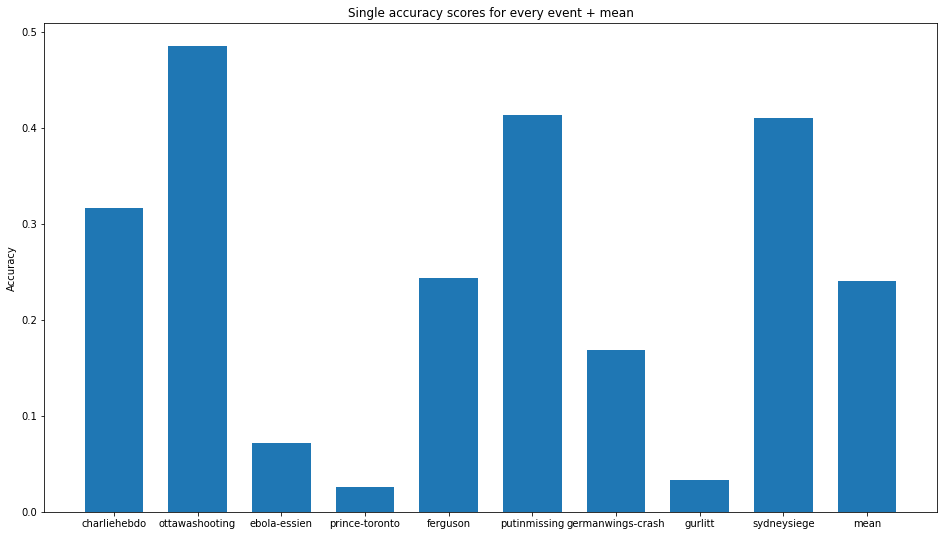

In [25]:
# Single accuracy scores for every event + mean

column_names = ['charliehebdo','ottawashooting',
'ebola-essien','prince-toronto',
'ferguson',	'putinmissing',
'germanwings-crash',
'gurlitt','sydneysiege','mean']

# creating the bar plot
fig = plt.figure(figsize = (16, 9))
plt.bar(column_names, scores, width = 0.7)
plt.ylabel("Accuracy")
plt.title("Single accuracy scores for every event + mean")
plt.show()

### Conclusions on the accuracy scores
On the plot above we can notice a lot of variance between each event. This is partially explained by the test size, given there’s some correlation between the size of the test and the accuracy score. 

But the relevant conclusion to highlight is that the **structure of a fake tweet can easily change for every event**. For the low score events the model didn't learn useful features from the fake news tweets belonging to the events seen during the training.


### What can be done to improve the accuracy?
Our results seems to suggest that the structure of a single tweet out of context, such as text, number of likes, retweet and data about the user, is not enough to infer its veracity.


We suggest two variants. Firstly, to look at the reaction of the tweet, i.e. the replies and retweets of other users. This kind of approach was used in the paper '[All-in-one: Multi-task Learning for Rumour Verification](https://arxiv.org/abs/1806.03713)', you can start from there if interested.
The second is to use a dataset of claims to give a context to the model, such as [FEVER](https://aclanthology.org/N18-1074/) for example

## Explainability
In our work, we were also interested in understanding the importance of each useful feature of the tweet. To do so we have implemented the [Shapely value tecnique](https://en.wikipedia.org/wiki/Shapley_value), using the [Shap library](https://shap.readthedocs.io/en/latest/index.html) in [this](https://www.kaggle.com/code/manuelcecerepalazzo/fake-news-detection-explainability-using-shap) notebook.